# Salary Prediction from LinkedIn Job Postings - Train XGBoost Model

In [1]:
import xgboost as xgb
import pandas as pd, numpy as np
import salary
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
import joblib

/Users/nginyc/repos/job_posting_salary_prediction/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme()

## Train & Tune Model

In [3]:
(X_train, y_train) = salary.get_train_dataset()
(X_test, y_test) = salary.get_test_dataset()

In [4]:
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('sbert_pca_encoder', make_pipeline(
                salary.SentenceBertEncoder(),
                StandardScaler(),
                PCA(n_components=0.9, random_state=42) 
            ), ['title']),
            ('one_hot_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('target_encoder', make_pipeline(
                TargetEncoder(random_state=42),
                StandardScaler(),
            ), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('experience_level', salary.experience_level_encoder, ['formatted_experience_level']),
            ('work_type', salary.work_type_encoder, ['formatted_work_type']),
            ('remote_allowed', 'passthrough', ['remote_allowed']),
            ('company_employee_count', make_pipeline(
                SimpleImputer(strategy='median'),
                StandardScaler(),
            ), ['company_employee_count']),
        ],
        remainder='drop'
    )
)

In [5]:
model_xgb = make_pipeline(
    clone(preprocessor),
    BayesSearchCV(
        estimator=xgb.XGBRegressor(n_estimators=500, objective='reg:tweedie', random_state=42),
        search_spaces={
            'max_depth': (7,),
            'min_child_weight': (5,),  
            'eta': (0.1,), 
            'subsample': (0.9,),
            'colsample_bytree': (0.5,), 
            'gamma': (0,),  
            'reg_alpha': (0.1,), 
            'reg_lambda': (0.1,)  
        },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_iter=1, 
        n_jobs=1,
        verbose=1,
        random_state=42
    )
).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [6]:
model_xgb

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('sbert_pca_encoder',
                                                                   Pipeline(steps=[('sentencebertencoder',
                                                                                    SentenceBertEncoder()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler()),
                                                                                   ('pca',
                                                                                    PCA(n_components=0.9,
                                                                                        random_state=42))]),
                                                                   ['title']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=Fals...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...),
                               n_iter=1, random_state=42, scoring='r2',
                               search_spaces={'colsample_bytree': (0.5,),
                                              'eta': (0.1,), 'gamma': (0,),
                                              'max_depth': (7,),
                                              'min_child_weight': (5,),
                                              'reg_alpha': (0.1,),
                                              'reg_lambda': (0.1,),
                                              'subsample': (0.9,)},
                               verbose=1))])

In [7]:
result_xgb_train = salary.evaluate_train_predictions(model_xgb.predict(X_train))
result_xgb_test = salary.evaluate_test_predictions(model_xgb.predict(X_test))

Train R2: 0.9546
Train RMSE: 13113.8567
Train MAE: 8127.5899
Test R2: 0.6305
Test RMSE: 35435.4191
Test MAE: 21623.7209


## Check Feature Importance

['title']


,Feature,Importance
0,target_encoder__norm_title,0.0599
1,experience_level__formatted_experience_level,0.052426
2,target_encoder__formatted_experience_level,0.051154
3,one_hot_encoder__formatted_experience_level_Entry level,0.032003
4,one_hot_encoder__company_industries_Legal Services,0.025923
5,target_encoder__clustered_edu_req,0.025059
6,target_encoder__company_industries,0.024748
7,one_hot_encoder__formatted_experience_level_Executive,0.024634
8,one_hot_encoder__formatted_work_type_Internship,0.021127
9,target_encoder__clustered_req_skill,0.018322


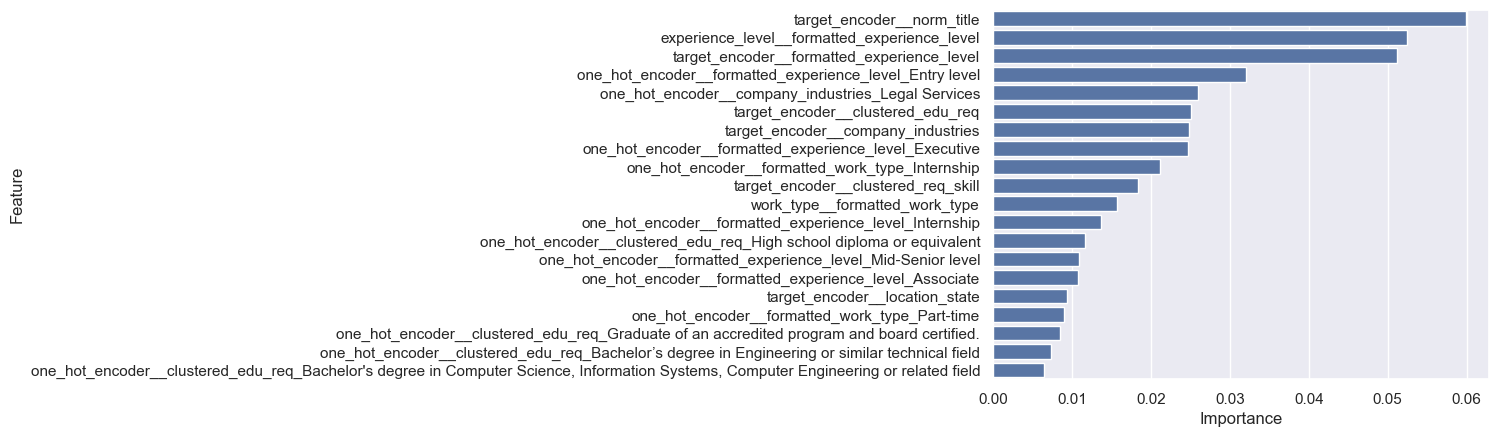

In [8]:
'''
Show top 20 important features
'''
def get_important_features(preocessor, model, n=20):
    feature_names = preocessor.get_feature_names_out(X_train.columns)
    importances = model.feature_importances_
    idxs = np.flip(np.argsort(np.abs(importances)))
    importance_df = pd.DataFrame([feature_names[idxs], importances[idxs]], index=["Feature", "Importance"]).transpose()
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(n))
    pd.set_option('display.max_colwidth', None)
    return importance_df[:n]


get_important_features(model_xgb[0], model_xgb[-1].best_estimator_)

## Do Error Analysis

In [ ]:
y_test_preds = model_xgb.predict(X_test)
resids = (y_test - y_test_preds).rename('residual')
abs_error = np.abs(resids).rename('abs_error')
X_test_results = pd.concat([X_test, y_test, pd.Series(y_test_preds, index=y_test.index, name='predicted_salary'), resids, abs_error], axis=1)
X_test_results

<Axes: xlabel='residual', ylabel='Count'>

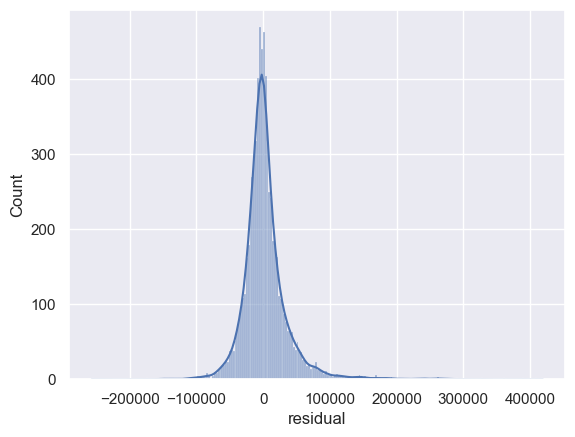

In [ ]:
# Residuals look pretty normally distributed
sns.histplot(X_test_results['residual'], kde=True)

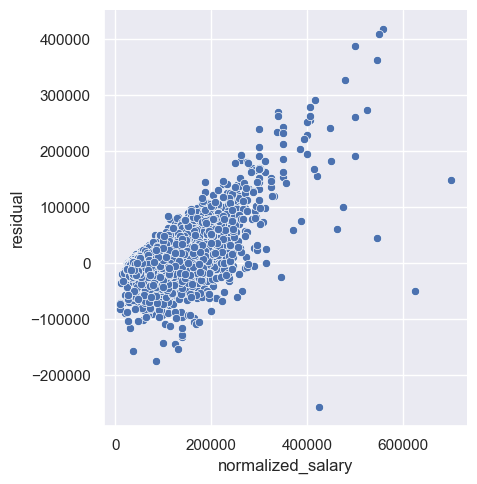

In [ ]:
'''
In general, the higher the residual, the more the model underestimates the salary.
It sometimes overestimates the salary for lower salaries.
'''
sns.relplot(x='normalized_salary', y='residual', data=X_test_results, kind='scatter')

In [ ]:
'''
Tends to underestimate (top 5): Nurse Practitioner, Phlebotomist, Associate Attorney, Electrical Engineer
Tends to overestimate (top 5): General Manager, Business Development Manager, Sales Representative, Accountant, Controller
'''
X_test_results.groupby('norm_title').agg({'residual': 'mean', 'norm_title': 'count'}).sort_values(by='residual')

,residual,norm_title
norm_title,,
Business Development Manager,-5047.424166,74
Executive Assistant,-3572.103920,68
Accountant,-3049.908203,54
Controller,-2991.434345,52
Sales Representative,-2905.652883,42
...,...,...
Team Member,9275.372984,25
Phlebotomist,10851.886316,38
Quality Engineer,11229.500881,156


In [ ]:
'''
Norm titles with the worst absolute errors
'''
X_test_results.groupby('norm_title').agg({'abs_error': 'mean', 'norm_title': 'count'}).sort_values(by='abs_error').tail(10)

,abs_error,norm_title
norm_title,,
Medical Assistant,29047.235741,176
Senior Software Engineer,29482.307357,273
Business Development Manager,29860.786835,74
General Manager,31716.045503,43
Senior Project Manager,32020.697844,110
Sales Executive,32462.391931,128
Associate Attorney,32800.674432,127
Nurse Practitioner,36653.529851,74
Mortgage Loan Officer,43025.990794,51


In [ ]:
X_test_results.groupby('formatted_experience_level').agg({'abs_error': 'mean', 'formatted_experience_level': 'count'}).sort_values(by='abs_error')

,abs_error,formatted_experience_level
formatted_experience_level,,
Internship,12764.815081,59
Entry level,13693.886681,1765
Associate,17720.556803,777
Unknown,23176.753168,1582
Mid-Senior level,25111.739830,2466
Director,34845.658748,250
Executive,65291.601477,73


In [ ]:
X_test_results.groupby('formatted_work_type').agg({'abs_error': 'mean', 'formatted_work_type': 'count'}).sort_values(by='abs_error')

,abs_error,formatted_work_type
formatted_work_type,,
Volunteer,4972.380859,2
Part-time,12057.085066,452
Internship,13367.256988,45
Temporary,16036.793716,69
Full-time,22178.073147,5632
Contract,23828.268923,748
Other,35929.857552,24


In [ ]:
X_test_results.sort_values(by='abs_error')[['job_id', 'title', 'norm_title', 'location', 'formatted_work_type', 'formatted_experience_level', 'normalized_salary', 'predicted_salary', 'residual']].tail(10)

,job_id,title,norm_title,location,formatted_work_type,formatted_experience_level,normalized_salary,predicted_salary,residual
17528,3901981451,Life Insurance Sales,Sales Specialist,United States,Other,Unknown,340000.0,76345.171875,263654.828125
17404,3901977375,Life Insurance Sales,Sales Specialist,"Phoenix metropolitan area, AZ",Other,Unknown,340000.0,69532.164062,270467.835938
5189,3888958396,"Stanford Cardiology, Electrophysiology",Electrical Engineer,"Pleasanton, CA",Full-time,Executive,525000.0,251971.875000,273028.125000
4080,3887881934,Real Estate Agent - Orange County (Buena Park),Mortgage Loan Officer,"Orange County, CA",Full-time,Unknown,405000.0,125055.406250,279944.593750
13114,3900966318,Asylum: Evidence Gathering Attorney,Associate Attorney,United States,Contract,Mid-Senior level,416000.0,125094.296875,290905.703125
17440,3901978687,Attorney,Associate Attorney,"California, United States",Contract,Unknown,480000.0,151742.484375,328257.515625
21460,3903443829,Obstetrics and Gynecology Physician,Medical Assistant,"Monroe, NY",Full-time,Mid-Senior level,546000.0,183670.765625,362329.234375
19587,3902780751,Director of Construction,Construction Project Manager,"Tuscaloosa, AL",Full-time,Unknown,500500.0,111843.945312,388656.054688
25067,3904389540,"Vice President, Client Relationship Manager, RIA/Family Office (Southwest)",OPERATIONS ASSISTANT MANAGER,"California, United States",Full-time,Executive,550000.5,139677.265625,410323.234375
459,3884434376,General Dermatologist,Phlebotomist,"Akron, OH",Full-time,Mid-Senior level,557500.0,138415.796875,419084.203125


## Export Best Model

In [ ]:
joblib.dump(model_xgb, 'models/best_model_xgb.pkl')

['models/best_model_xgb.pkl']